## Create the Data Set for the Experiments

**Objective** <br>
create the image dataset of the validated and putative off-targets extracted 
from the crispor data set and maximilianh github. <br>

**Procedure** <br>
1. remove the positive labels from the crispor-encoded-data
2. transform the encoded data into a data frame
3. add the positive labels based on the crispor paper github with encoded sequence
4. transform the encoded sequences as an image for the deep neural network experiments

**Encoded crispor data set description** <br>
*   positive labels: 143 validated off-targets
*   negative labels: [len(mm_scores)=26,052 putative off-targets] - positive labels

**Maximiliah validated off-targets data set description** <br>
*   positive labels: 718 validated off-targets



In [0]:
import sys
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import Bunch

In [2]:
# we import the pkl encoded data
mm_scores = pkl.load(open('crispor_encoded_data.pkl','rb'), encoding='latin1')

# we check the off-target label
# validated off-targets identified by CRISPOR labeled as 1
nb_val_off_target = np.sum(mm_scores[1])
print("There is %s validated off-targets identified" % nb_val_off_target)

# we convert the encoded data to a pandas dataframe
df_enc = pd.DataFrame(mm_scores[0])
df_enc['label'] = mm_scores[1]
df_enc

# we remove the validated encoded off-targets to replace them from the 
# the validated off-targets from maximilianh. We only keep the putative 
# off-targets
df_enc = df_enc[df_enc['label'] == 0]

There is 177 validated off-targets identified


In [3]:
# we import the validated off-targets from maximilianh
fpath = 'validated_offtargets_.tsv'
df_max = pd.read_csv(fpath, sep='\t')
df_max = df_max[['name', 'guideSeq', 'otSeq']]
df_max['label'] = 1.0
df_max

,name,guideSeq,otSeq,label
0,Frock_RAG1B,GACTTGTTTTCATTGTTCTCAGG,TCCTTGTTTTCATTGTTCTCTGG,1.0
1,Kim16_VEGFA2,GACCCCCTCCACCCCGCCTCCGG,CTCCCCACCCACCCCGCCTCAGG,1.0
2,Cho_ccr5-7,AACACCAGTGAGTAGAGCGGAGG,AACACCAGCGAGTAGAGCGGAGG,1.0
3,Frock_EMX,GAGTCCGAGCAGAAGAAGAAGGG,GAGTCTAAGCAGAAGAAGAAGAG,1.0
4,Cho_ccr5-6,ATGAACACCAGTGAGTAGAGCGG,ATGAACACCAGCGAGTAGAGCGG,1.0
...,...,...,...,...
712,Hsu_EMX1.3,GAGTCCGAGCAGAAGAAGAAGGG,GAGTCCGAGAAAATGAAGAAGAG,1.0
713,Hsu_EMX1.3,GAGTCCGAGCAGAAGAAGAAGGG,GATTCCTACCAGAAGAAGAATGG,1.0
714,Hsu_EMX1.6,GCGCCACCGGTTGATGTGATGGG,GGGCCATGGGTTGATGTGATGAG,1.0
715,Ran_EMX1-sg1,GCCTCCCCAAAGCCTGGCCAGGG,GCCTGCCGAAGGCCTGGCCAGGG,1.0


In [4]:
# we encode the new validated off-targets
# as described in the references
def one_hot_encode_seq(data):
    # define universe of possible input values
    alphabet = 'AGCT'
    # define a mapping of chars to integers
    char_to_int = dict((c, i) for i, c in enumerate(alphabet))
    int_to_char = dict((i, c) for i, c in enumerate(alphabet))
    # integer encode input data
    integer_encoded = [char_to_int[char] for char in data]
    # print(integer_encoded)
    # one hot encode
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))]
        letter[value] = 1
        onehot_encoded.append(letter)
    # print(onehot_encoded)
    # invert encoding
    inverted = int_to_char[np.argmax(onehot_encoded[0])]
    # print(inverted)
    return onehot_encoded

def flatten_one_hot_encode_seq(seq):
    return np.asarray(seq).flatten(order='C')

enc_dna_list = []
enc_rna_list = []
encoded_list = []
for n in range(len(df_max)):
    target_dna = df_max.loc[n, 'otSeq']
    target_rna = df_max.loc[n, 'guideSeq']
    arr1 = one_hot_encode_seq(target_dna)
    arr2 = one_hot_encode_seq(target_rna)
    arr = np.zeros((23,4))
    for m in range(len(arr1)):
        if arr1[m] == arr2[m]:
            arr[m] = arr1[m]
        else:
            arr[m] = np.add(arr1[m], arr2[m])
    arr = flatten_one_hot_encode_seq(arr)
    enc_dna_list.append(np.asarray(arr1).flatten('C'))
    enc_rna_list.append(np.asarray(arr2).flatten('C'))
    encoded_list.append(np.asarray(arr).flatten('C'))

df_max['enc_dna'] = pd.Series(enc_dna_list)
df_max['enc_rna'] = pd.Series(enc_rna_list)
df_max['encoded'] = pd.Series(encoded_list)
df_max

,name,guideSeq,otSeq,label,enc_dna,enc_rna,encoded
0,Frock_RAG1B,GACTTGTTTTCATTGTTCTCAGG,TCCTTGTTTTCATTGTTCTCTGG,1.0,"[0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, ..."
1,Kim16_VEGFA2,GACCCCCTCCACCCCGCCTCCGG,CTCCCCACCCACCCCGCCTCAGG,1.0,"[0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, ...","[0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
2,Cho_ccr5-7,AACACCAGTGAGTAGAGCGGAGG,AACACCAGCGAGTAGAGCGGAGG,1.0,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, ...","[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Frock_EMX,GAGTCCGAGCAGAAGAAGAAGGG,GAGTCTAAGCAGAAGAAGAAGAG,1.0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
4,Cho_ccr5-6,ATGAACACCAGTGAGTAGAGCGG,ATGAACACCAGCGAGTAGAGCGG,1.0,"[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...","[1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, ...","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...,...,...
712,Hsu_EMX1.3,GAGTCCGAGCAGAAGAAGAAGGG,GAGTCCGAGAAAATGAAGAAGAG,1.0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
713,Hsu_EMX1.3,GAGTCCGAGCAGAAGAAGAAGGG,GATTCCTACCAGAAGAAGAATGG,1.0,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
714,Hsu_EMX1.6,GCGCCACCGGTTGATGTGATGGG,GGGCCATGGGTTGATGTGATGAG,1.0,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, ..."
715,Ran_EMX1-sg1,GCCTCCCCAAAGCCTGGCCAGGG,GCCTGCCGAAGGCCTGGCCAGGG,1.0,"[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."


In [5]:
# we extract the values from the dataframe df_max to merge with the global df
df_to_merge = pd.DataFrame(df_max['encoded'].values.tolist())
df_to_merge['label'] = 1
df_to_merge

# we merge the 2 df
df_enc = df_enc.append(df_to_merge, ignore_index=True)

# we replace the name of the validated off-targets
df_enc['name'] = 'na'
df_enc.loc[df_enc['label'] == 1, 'name'] = df_max['name'].values
df_enc

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,label,name
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,na
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,na
2,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,na
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0,na
4,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0,na
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26587,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,Hsu_EMX1.3
26588,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,Hsu_EMX1.3
26589,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,Hsu_EMX1.6
26590,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,Ran_EMX1-sg1


In [6]:
# A -> [1, 0, 0, 0]
# G -> [0, 1, 0, 0]
# C -> [0, 0, 1, 0]
# T -> [0, 0, 0, 1]

# 23 is the length of the sequence which includes the 3-bp PAM adjacent to the 20 bases
# 23 (sequence length) x 4 (size of nucleotides vocabulary)
# 26 034 putative off-targets including 143 validated off-targets identified by CRISPOR

# we want to transform the encoded putative to 8x23
# we only keep the encoded putative
put_mm_score = df_enc[df_enc['label'] == 0].iloc[:,0:92].values

dc = ['A', 'G', 'C', 'T']
seq_sgRNA_DNA = np.chararray((2 * len(put_mm_score),23))
seq_sgRNA_DNA[:] = ''
indx_counter = 0
indx_seq = 0

for iline in range(len(put_mm_score)): # range(3):
  arr = put_mm_score[iline]
  arr = arr.reshape((4,23), order='F')

  # check if the encoded sgRNA-DNA sequence is > 2. => reshape is incorrect
  if (np.sum(arr, axis=0) > 3).any() == True:
    raise ValueError("Incorrect reshape of the flattening. Error at line ", iline)

  for n in range(arr.shape[1]):
    loc_bp = np.where(arr[:,n] == 1)[0]
    indx_seq = 0
    for indx_loc_bp in loc_bp:
      seq_sgRNA_DNA[indx_counter + indx_seq, n] = dc[indx_loc_bp]
      if len(loc_bp) == 1:
        seq_sgRNA_DNA[indx_counter + indx_seq + 1, n] = seq_sgRNA_DNA[indx_counter + indx_seq, n]
      indx_seq += 1

  indx_counter += 2

seq_sgRNA_DNA[0].decode()
pd.DataFrame(seq_sgRNA_DNA.decode())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22
0,G,A,G,T,C,C,G,A,G,C,A,A,A,A,G,A,A,G,A,A,G,G,A
1,G,A,G,T,C,C,C,A,G,C,A,G,G,A,G,A,A,G,A,G,T,G,G
2,G,A,G,T,G,G,G,A,G,C,A,G,A,A,G,A,A,G,A,A,G,G,A
3,G,A,G,T,C,C,G,A,G,C,G,G,C,A,G,A,A,G,A,A,G,G,G
4,G,A,G,G,C,A,A,A,G,A,A,G,A,A,G,A,A,G,A,A,A,G,G
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
51745,C,T,T,G,C,C,C,C,A,C,A,G,T,G,C,A,G,T,A,A,C,G,G
51746,C,T,T,G,C,C,C,C,A,C,A,G,G,G,A,A,G,T,A,A,C,G,G
51747,C,T,T,G,C,C,C,T,C,C,A,G,G,G,C,A,G,T,A,C,T,G,G
51748,C,T,T,G,C,C,C,C,A,C,A,G,G,A,C,A,G,C,A,A,C,G,G


In [9]:
# we have to transform the RNA and DNA sequences to
# a 8x23 image

# we structure the images as the mnist dataset
# digits.target_names is the name
# digits.target is the binary classification
# digits.images is the 8x23 pixels of the image
#a. we do it for the put. off-target

# we store the image in im
im = np.zeros((len(put_mm_score) + len(df_max), 8, 23))

cnt = 0
for n in range(0, len(seq_sgRNA_DNA), 2):
  arr1 = one_hot_encode_seq("".join(seq_sgRNA_DNA[n].decode()))
  arr1 = np.asarray(arr1).T
  arr2 = one_hot_encode_seq("".join(seq_sgRNA_DNA[n + 1].decode()))
  arr2 = np.asarray(arr2).T
  arr = np.concatenate((arr1, arr2)) * 254
  im[cnt] = arr
  cnt += 1

#b. we do it for the val. off-target
for n in range(len(df_max)):
  arr1 = one_hot_encode_seq(df_max.loc[n, 'guideSeq'])
  arr1 = np.asarray(arr1).T
  arr2 = one_hot_encode_seq(df_max.loc[n, 'otSeq'])
  arr2 = np.asarray(arr2).T
  arr = np.concatenate((arr1, arr2)) * 254
  im[cnt] = arr
  cnt += 1

# we put the results in bunch
digits = Bunch(
    target_names = df_enc['name'].values, 
    target=df_enc['label'].values, 
    images=im
)
digits

{'images': array([[[  0., 254.,   0., ...,   0.,   0., 254.],
         [254.,   0., 254., ..., 254., 254.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [254.,   0., 254., ...,   0., 254., 254.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ..., 254.,   0.,   0.]],
 
        [[  0., 254.,   0., ...,   0.,   0., 254.],
         [254.,   0., 254., ..., 254., 254.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [254.,   0., 254., ..., 254., 254., 254.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],
 
        [[  0., 254.,   0., ..., 254.,   0.,   0.],
         [254.,   0., 254., ...,   0., 254., 254.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         ...,
         [254.,   0., 254., ..., 254., 254., 254.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.],
         [  0.,   0.,   0., ...,   0.,   0.,   0.]],
 
   

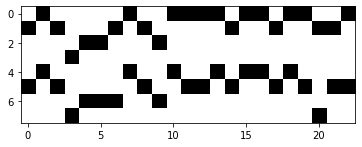

In [12]:
plt.imshow(im[0], cmap='Greys')